In [1]:
# Import libraries
import os
import glob
import pandas as pd
import xarray as xr
import numpy as np
import scipy.stats # for calculation of trend

from tqdm import tqdm # progressbar

# Define function to calculate the trendn
def calc_trend(ndarray, t):
    """Calculate linear trend
    Inputs
    ------
    x: numpy array with original data
    t: np array with timestamps
    
    Returns
    --------
    T: estimate of the linear trend    
    """
    slope = scipy.stats.linregress(t, ndarray).slope
    intercept = scipy.stats.linregress(t, ndarray).intercept
    T = t*slope + intercept
    return(T)

In [2]:
# Read in data

LAI = xr.open_dataset('/media/stijndc/data/datafiles/SAT_EX/netcdf_files_original/GLASSLAI2/GLASSLAI.AVHRR.V004.1982-2015_1.nc')
LAI

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1564)
Coordinates:
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 -176.0 -175.0 -174.0 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * time     (time) datetime64[ns] 1982-01-01 1982-01-09 1982-01-17 ...
Data variables:
    LAI      (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...
Attributes:
    CDI:                       Climate Data Interface version ?? (http://mpim...
    Conventions:               CF-1.4
    history:                   Tue Feb 21 19:23:55 2017: cdo -P 4 remapbil,/m...
    cdo_openmp_thread_number:  4
    CDO:                       Climate Data Operators version 1.7.0 (http://m...

In [4]:
# Extract to numpy
print('Extracting data to numpy...')
LAI_npdata = LAI['LAI'].values
npshape = LAI_npdata.shape
print('Done!')

Extracting data to numpy...
Done!


In [5]:
# set resolution
resolution = 'weekly' # one of ['monthly', 'weekly', 'daily']

In [6]:
# Numpy array to store trend component
LAI_trend_np = np.ndarray(shape=npshape)

print('Starting loop...')
# Loop over pixels, store the trend component 
for lat in tqdm(range(0,len(LAI.lat))):
    for lon in range(0,len(LAI.lon)):
        if not np.all(np.isnan(LAI_npdata[:,lat,lon])): # skip if all data is NaN for this pixel
            LAI_trend_np[:,lat,lon] = calc_trend(LAI_npdata[:,lat,lon], np.arange(0,npshape[0]))
        else:
            LAI_trend_np[:,lat,lon]=np.nan
            
print('Detrending done...')

# Store trend component in xarray dataArray
LAI_trend = xr.DataArray(LAI_trend_np, dims=['time', 'lat', 'lon'],
                               coords=LAI.coords)
# Calculate detrended data
LAI_detrended = LAI - LAI_trend

# Estimate cycle component
# Conform the cycle component onto the same index as the detrended data, and extract to numpy array so we
# can extract it element-wise

if resolution == 'monthly':
    y_w_mean = LAI_detrended.groupby('time.month').mean(dim='time') # monthly resolution
    y_w_mean_expanded = y_w_mean.reindex({'month': LAI_detrended.time.to_series().index.month})['LAI'].values 
elif resolution == 'weekly':
    y_w_mean = LAI_detrended.groupby('time.weekofyear').mean(dim='time') # weekly resolution
    y_w_mean_expanded = y_w_mean.reindex({'weekofyear': LAI_detrended.time.to_series().index.weekofyear})['LAI'].values 
elif resolution == 'daily':
    y_w_mean = LAI_detrended.groupby('time.dayofyear').mean(dim='time') # daily resolution
    y_w_mean_expanded = y_w_mean.reindex({'dayofyear': LAI_detrended.time.to_series().index.dayofyear})['LAI'].values 

else:
    print('Provide adequate resolution')

# Finally, obtain residuals
LAI_resid = LAI_detrended-y_w_mean_expanded

print('Done!')

  0%|          | 0/180 [00:00<?, ?it/s]

Starting loop...


100%|██████████| 180/180 [00:10<00:00, 17.29it/s]


Detrending done...
Done!


In [37]:
LAI_resid = LAI_resid.sel(lat=slice(None,None,-1))

In [41]:
# dump
idx = 'LAI_residuals.nc'.format(resolution) 
LAI_resid.to_netcdf('/media/stijndc/data/datafiles/SAT_EX/netcdf_files_processed/{}'.format(idx))


syncing


# Sanity checks

In [7]:
#inspect different components
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('seaborn-white')

Visualize the different components for a given lat and lon:

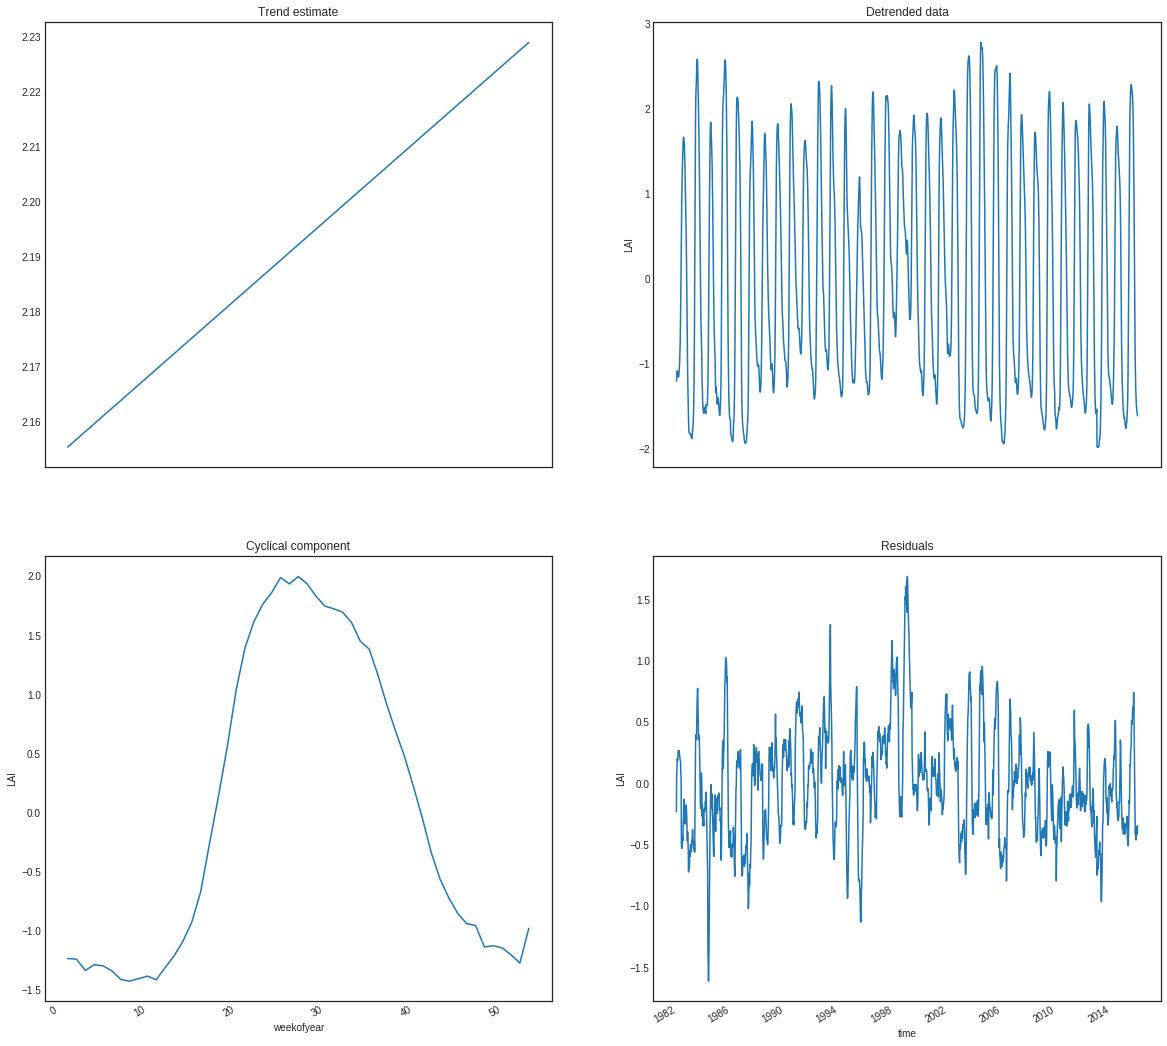

In [8]:
# Pick latitude and longitude to visualize
lat = 50
lon = 10

fig, (axrow1, axrow2) = plt.subplots(nrows=2, ncols=2, figsize=(20,20))

try:
    LAI_trend.sel(lat=lat, lon=lon, method='nearest').plot(ax=axrow1[0])
    LAI_detrended['LAI'].sel(lat=lat, lon=lon, method='nearest').plot(ax=axrow1[1])
    y_w_mean['LAI'].sel(lat=lat, lon=lon, method='nearest').plot(ax=axrow2[0])
    LAI_resid['LAI'].sel(lat=lat, lon=lon, method='nearest').plot(ax=axrow2[1])
    axrow1[0].set_title('Trend estimate')
    axrow1[1].set_title('Detrended data')
    axrow2[0].set_title('Cyclical component')
    axrow2[1].set_title('Residuals')

except():
    print('No data in this pixel...')

Visualize the components for a given point in time:

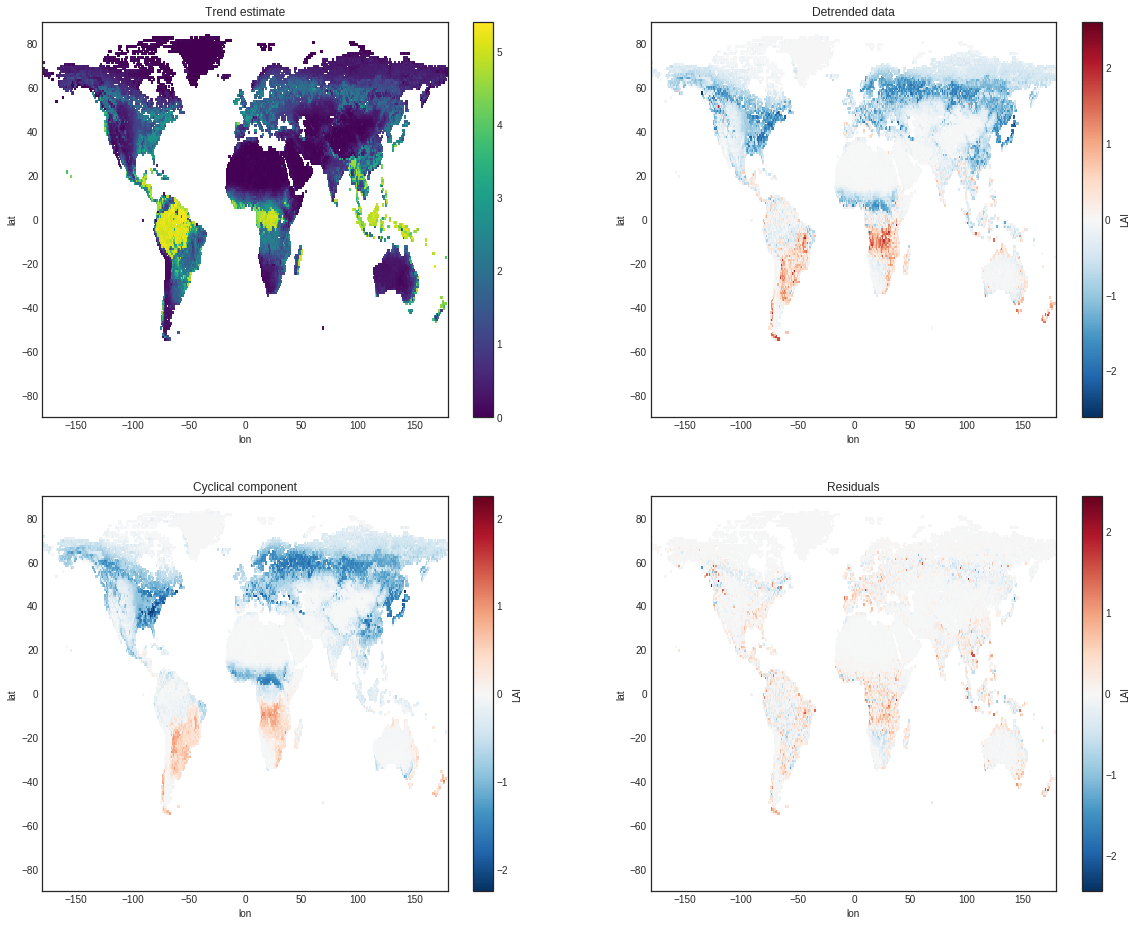

In [9]:
# Pick timestamp to visualize
timestamp = '1995-01-01'
fig, (axrow1, axrow2) = plt.subplots(nrows=2, ncols=2, figsize=(20,16))

try:
    LAI_trend.sel(time=timestamp, method='nearest').plot(ax=axrow1[0])
    LAI_detrended['LAI'].sel(time=timestamp, method='nearest').plot(ax=axrow1[1])
    if resolution == 'monthly':
        y_w_mean['LAI'].sel(month=pd.to_datetime(timestamp).month, method='nearest').plot(ax=axrow2[0])
    elif resolution == 'weekly':
        y_w_mean['LAI'].sel(weekofyear=pd.to_datetime(timestamp).weekofyear, method='nearest').plot(ax=axrow2[0])
    elif resolution == 'daily':
        y_w_mean['LAI'].sel(dayofyear=pd.to_datetime(timestamp).dayofyear, method='nearest').plot(ax=axrow2[0])
    LAI_resid['LAI'].sel(time=timestamp, method='nearest').plot(ax=axrow2[1])
    axrow1[0].set_title('Trend estimate')
    axrow1[1].set_title('Detrended data')
    axrow2[0].set_title('Cyclical component')
    axrow2[1].set_title('Residuals')

except():
    print('No data in this pixel...')